In [1]:
#下記パッケージについて、インストールされていない場合は、import Pkg; Pkg.add("パッケージ名")を実行する。
using Plots
using Interpolations
using LaTeXStrings 

In [2]:
function polybas(kmin,kmax,Np,kgrid)
    """
    ----------------------------------------
    === 基底関数の行列を再帰的に求める関数 ===
    ----------------------------------------
    <input>
    ・kmin: 状態変数のグリッドの最小値
    ・kmax: 状態変数のグリッドの最大値
    ・Np: 多項式の次数-1   
    ・kgrid: 状態変数のグリッド(Ng個)
    <output>
    ・T: 基底関数の行列(NgxNp)
    (Ng個の評価点でNp-1次のチェビシェフ多項式で近似する)
    """
    Ng = length(kgrid) # グリッドの数
    x = (2/(kmax-kmin))*(kgrid .- kmin) .- 1 # グリッドを[-1,1]の範囲に変換

    # 基底関数の行列(NgxNp)を再帰的に求める
    T = zeros(Ng,Np)
    T0 = ones(Ng)
    T1 = x
    T2 = 2 .* x .* T1 .- T0
    T[:,1] = T1
    T[:,2] = T2
    
    for i in 3:Np-1
        T[:,i] = 2 .* x .* T[:,i-1] .- T[:,i-2]
    end

    T = [T0 T[:,1:(Np-1)]]

    return T

end

polybas (generic function with 1 method)

In [3]:
function polygrid(kmin,kmax,N)
    """
    -----------------------------------------------
    === チェビシェフ多項式における評価点を返す関数 ===
    -----------------------------------------------
    <input>
    ・kmin: 状態変数のグリッドの最小値
    ・kmax: 状態変数のグリッドの最大値
    ・N: 状態変数のグリッド数
    <output>
    ・k: 状態変数のグリッド
    """
    # チェビシェフ極値点
    temp = collect(range(0,N-1,length=N))
    x = -cos.((pi/(N-1)).*temp)
    
    # チェビシェフゼロ点
    #x = -cos.((pi/2/(N-1) .* (2*temp.-1)))
    #x[1] = 0.0

    # x([-1,1])からk([kmin,kmax])に変換
    k = 0.5.*(kmax-kmin).*(x.+1) .+ kmin

    return k

end

polygrid (generic function with 1 method)

In [4]:
function f(x0)
    """
    ------------------
    === ルンゲ関数 ===
    ------------------
    """
    nx = length(x0)
    f0 = ones(nx) ./ (ones(nx).+25*x0.^2)

    return f0

end

f (generic function with 1 method)

### cheb_demo.m に対応

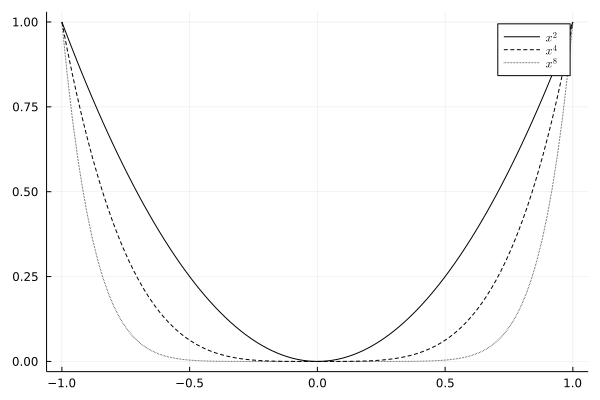

In [5]:
# ordinary polynomial
x = collect(range(-1,1,length=101))
plot(x,x.^2,c=:black,lw=1,ls=:solid,label=L"x^2")
plot!(x,x.^4,c=:black,lw=1,ls=:dash,label=L"x^4")
plot!(x,x.^8,c=:black,lw=1,ls=:dot,label=L"x^8")
#savefig("ordipoly.pdf")

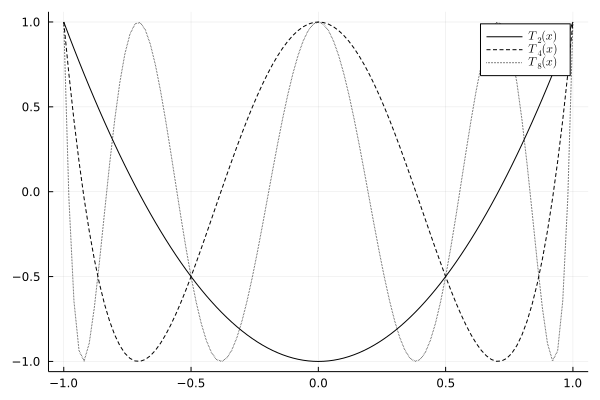

In [6]:
# Chebyshev polynomial
T = polybas(-1,1,9,x);

plot(x,T[:,3],c=:black,ls=:solid,lw=1,label=L"T_2(x)")
plot!(x,T[:,5],c=:black,ls=:dash,lw=1,label=L"T_4(x)")
plot!(x,T[:,9],c=:black,ls=:dot,lw=1,label=L"T_8(x)")
#savefig("chebpoly.pdf")

### how_to_interpolate_cheb.m に対応

In [7]:
# データ点
xmin = -1;
xmax = 1;
nxd = 11;
xd = collect(range(xmin,xmax,length=nxd));
yd = f(xd);

# 関数による値
nx = 1001;
x0 = collect(range(xmin,xmax,length=nx));
y0 = f(x0);

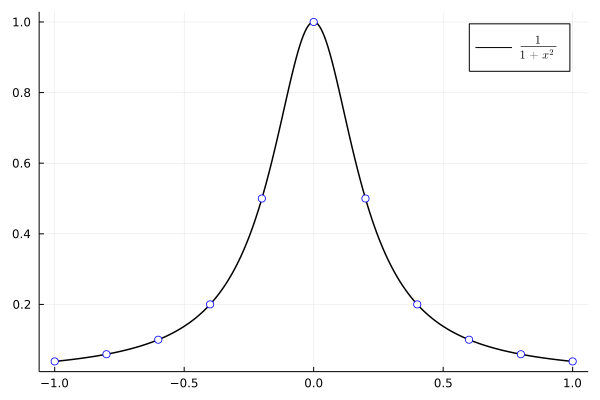

In [8]:
plot(x0,y0,c=:black,lw=1.5,label=L"$\frac{1}{1+x^{2}}$")
plot!(xd,yd,st=:scatter,mc=:white,msc=:blue,label="")
#savefig("Fig_data.pdf")

In [9]:
# Julia関数(Interpolations.LinearInterpolation)を使った線形補間による近似
x1 = collect(range(xmin,xmax,nx));
# (xd,yd)による線形補間した関数を定義する
# Matlab関数(interp1)は補間と評価を1つの関数で行うが、interpolate関数では補間と評価を別々に行う。
interp_y1 = LinearInterpolation(xd,yd);
y1 = interp_y1.(x1);

In [13]:
# 通常の多項式による近似
Xd = ones(nxd,nxd);
X2 = ones(nx,nxd);
x2 = x1;
for i in 1:nxd-1
    Xd[:,i+1] .= xd.^i;
    X2[:,i+1] .= x2.^i;
end

b = (Xd' * Xd)\(Xd'*yd);
y2 = X2*b;

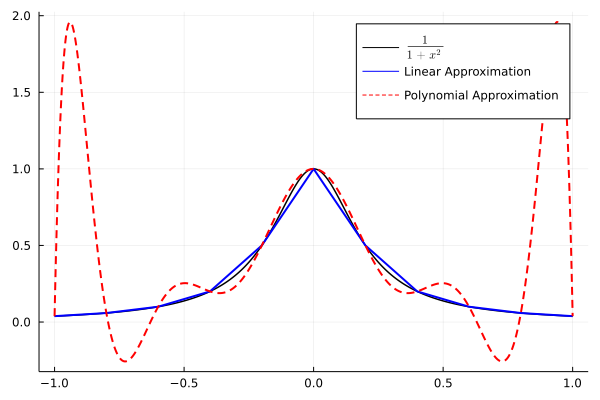

In [16]:
plot(x0,y0,c=:black,lw=1.5,label=L"$\frac{1}{1+x^{2}}$")
plot!(x1,y1,c=:blue,lw=2.0,label="Linear Approximation")
plot!(x2,y2,ls=:dash,c=:red,lw=2.0,label="Polynomial Approximation")
#savefig("Fig_interp.pdf")

In [17]:
# チェビシェフ多項式による近似(N=11)
nxd = 11;
xcheb = polygrid(xmin,xmax,nxd);
ycheb = f(xcheb);
T = polybas(xmin,xmax,nxd,xcheb);
theta = T\ycheb;

x3 = x1;
T3 = polybas(xmin,xmax,nxd,x3);
y3 = T3*theta;

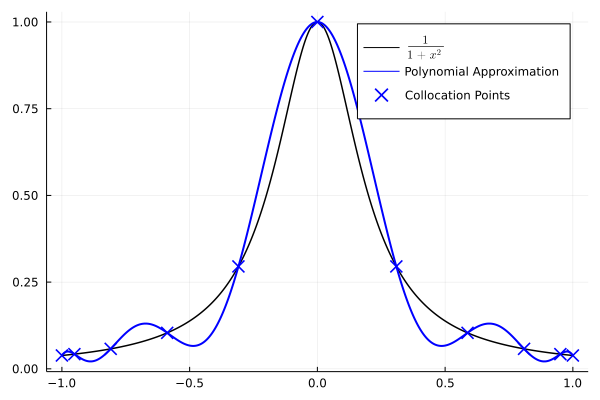

In [19]:
plot(x0,y0,c=:black,lw=1.5,label=L"$\frac{1}{1+x^{2}}$")
plot!(x3,y3,c=:blue,lw=2.0,label="Polynomial Approximation")
plot!(xcheb,ycheb,c=:blue,st=:scatter,shape=:xcross,ms=6,msw=2,label="Collocation Points")
#savefig("Fig_cheb_n11.pdf")

In [20]:
# チェビシェフ多項式による近似(N=21)
nxd = 21;
xcheb = polygrid(xmin,xmax,nxd);
ycheb = f(xcheb);
T = polybas(xmin,xmax,nxd,xcheb);
theta = T\ycheb;

x3 = x1;
T3 = polybas(xmin,xmax,nxd,x3);
y3 = T3*theta;

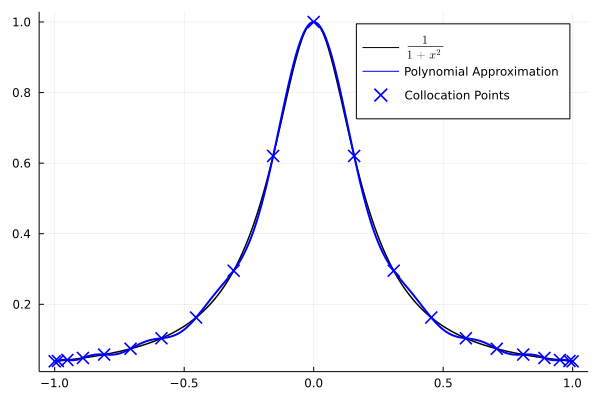

In [22]:
plot(x0,y0,c=:black,lw=1.5,label=L"$\frac{1}{1+x^{2}}$")
plot!(x3,y3,c=:blue,lw=2.0,label="Polynomial Approximation")
plot!(xcheb,ycheb,c=:blue,st=:scatter,shape=:xcross,ms=6,msw=2,label="Collocation Points")
#savefig("Fig_cheb_n21.pdf")